In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import ElasticNet
from nonconformist.cp import IcpRegressor
from nonconformist.cp import IcpClassifier
from nonconformist.nc import NcFactory
import pickle
import re
import warnings
warnings.filterwarnings('ignore')

In [4]:
results = pd.read_csv('data/4_validation_result.csv')
train_input = pd.read_csv('3_data/train_model_input.csv')
test_input = pd.read_csv('3_data/test_model_input.csv')
final_test = pd.read_csv('data/test.csv')

X_train = train_input.iloc[:,0:6]
y_train = train_input.iloc[:,-1]
X_test = test_input.iloc[:,0:6]
y_test = test_input.iloc[:,-1]

FileNotFoundError: [Errno 2] No such file or directory: 'data/4_validation_result.csv'

In [24]:
bootstraps = []
for model in list(set(results.model.values)):
    model_df = results.loc[results.model == model]
    bootstrap = model_df.sample(n=50, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

In [25]:
metric_df = results_long_nofit[results_long_nofit.metrics == 'test_neg_mean_squared_error']
metric_df['values'] = (metric_df['values']*(-1))**(1/2)

Text(0.5, 1.0, 'Comparison of Model by RMSE')

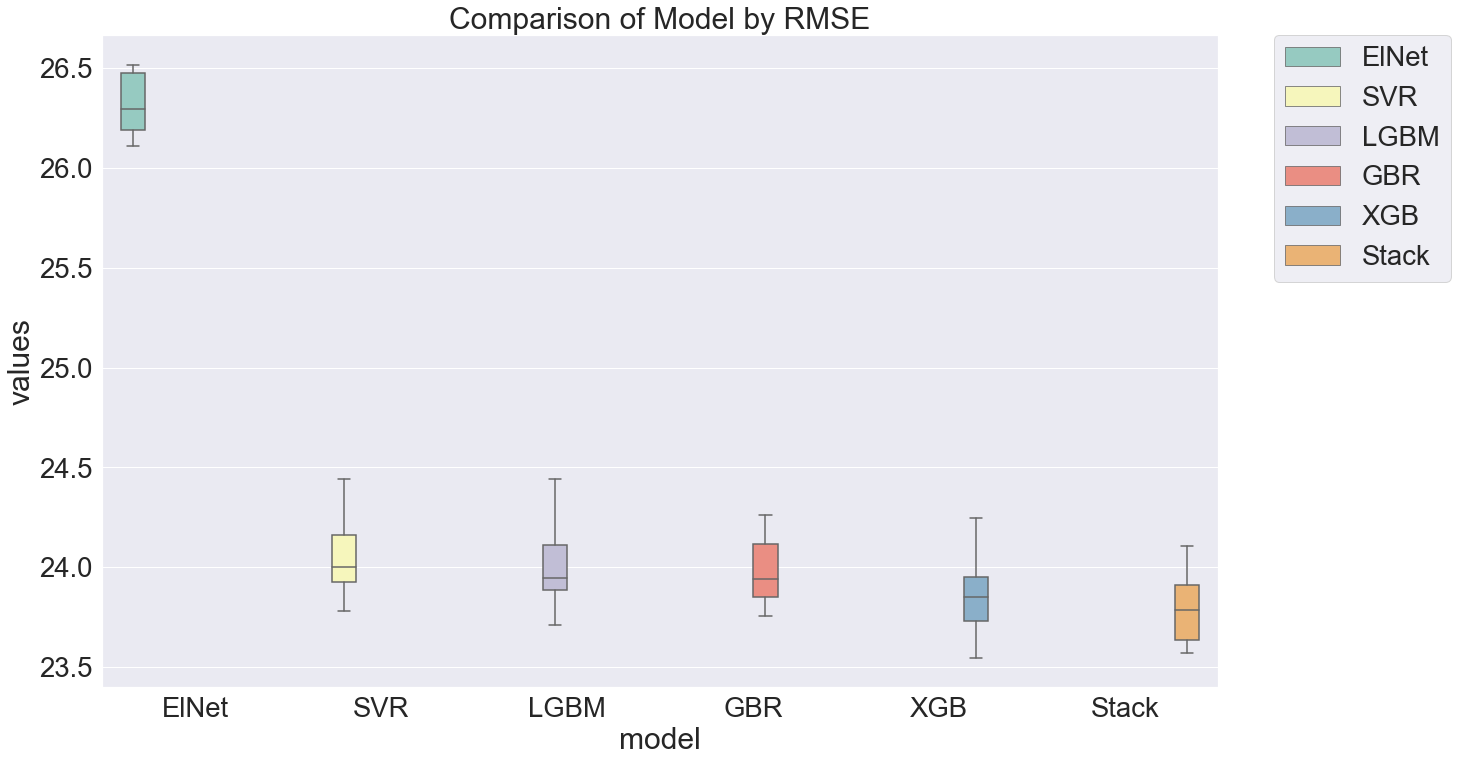

In [26]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="model", data=metric_df, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by RMSE')

In [27]:
metric_df = results_long_nofit[results_long_nofit.metrics == 'test_r2']

Text(0.5, 1.0, 'Comparison of Model by R-squared')

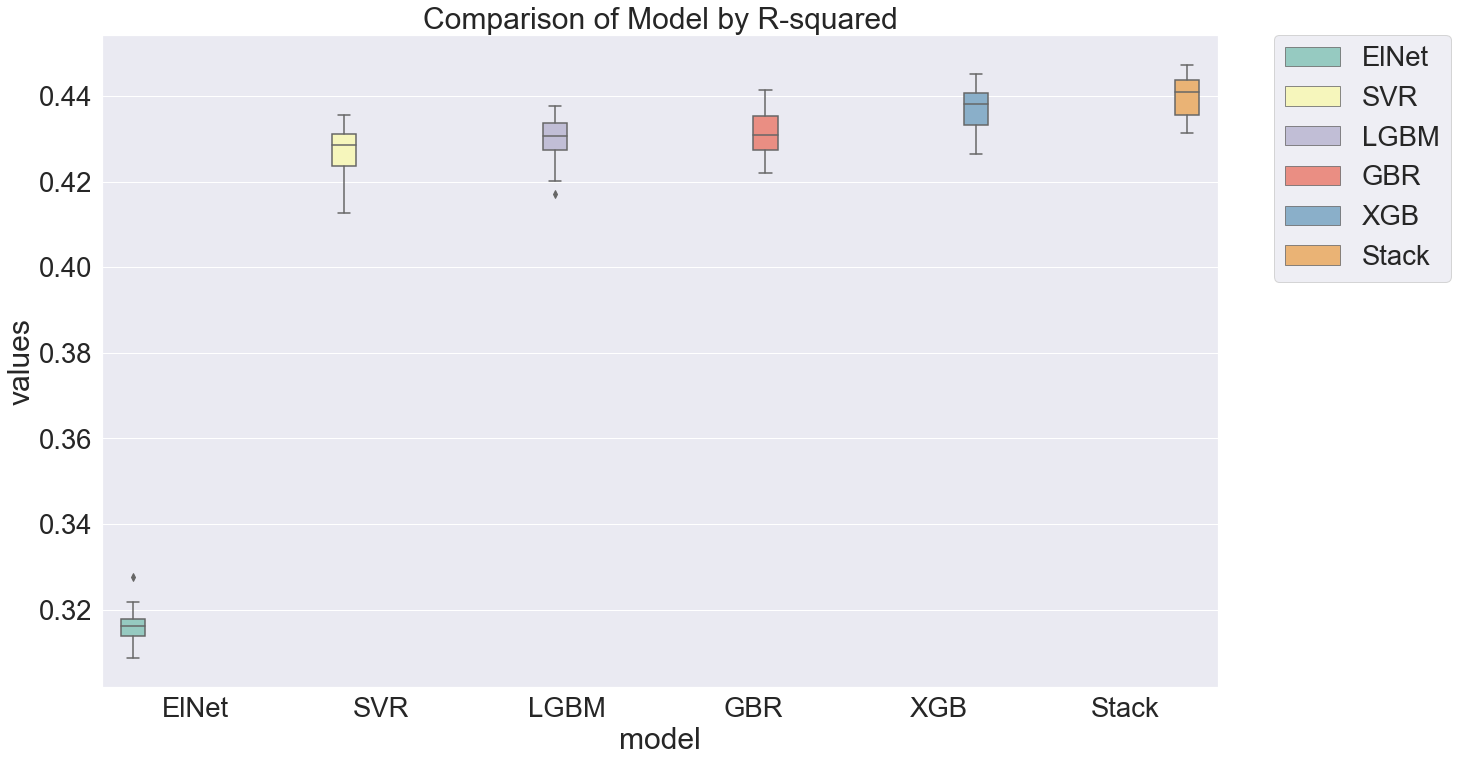

In [28]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="model", data=metric_df, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by R-squared')

Text(0.5, 1.0, 'Comparison of Model by Fit Time')

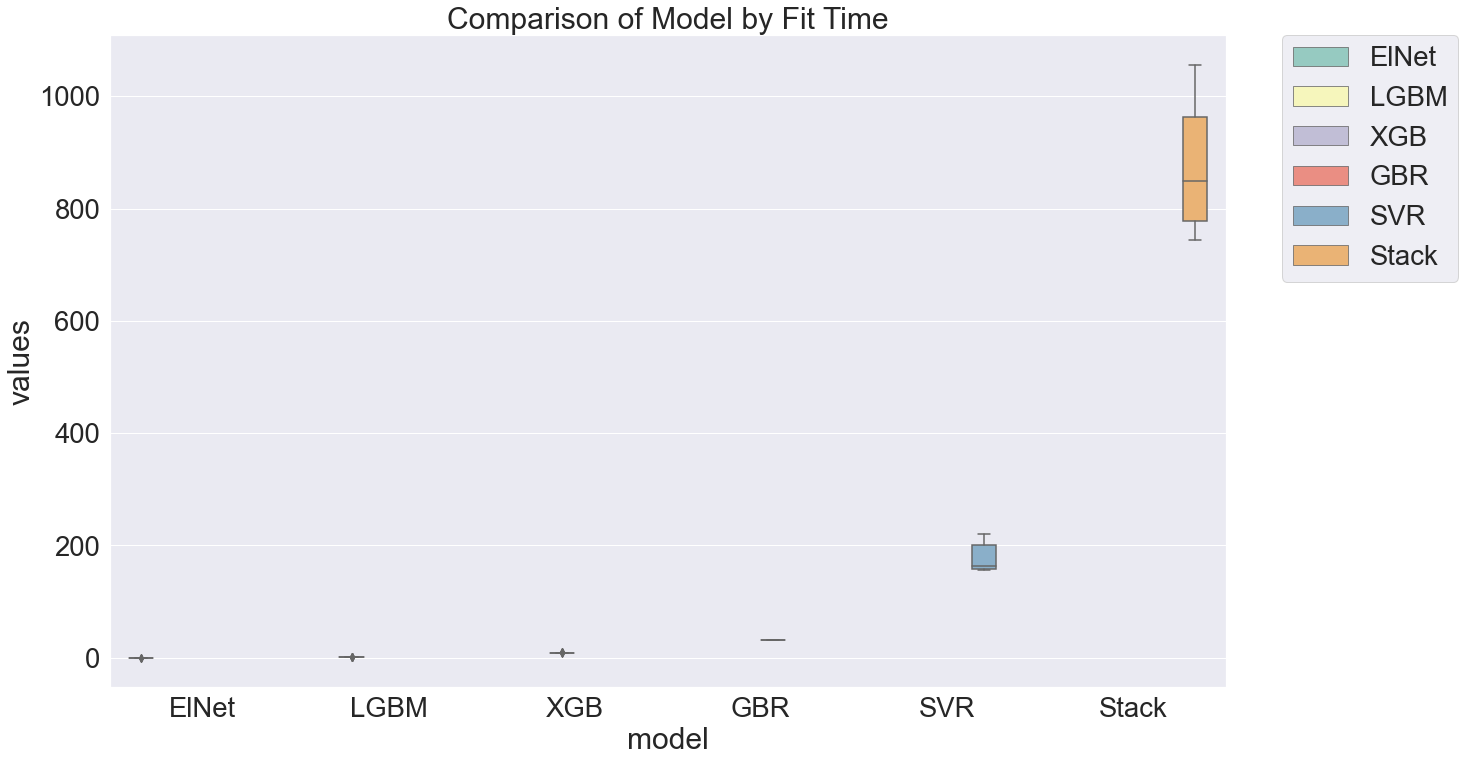

In [29]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="model", data=results_long_fit[results_long_fit.metrics =='fit_time'], palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit Time')
#plt.savefig('./benchmark_models_time.png',dpi=300)

Text(0.5, 1.0, 'Comparison of Model by FitTime')

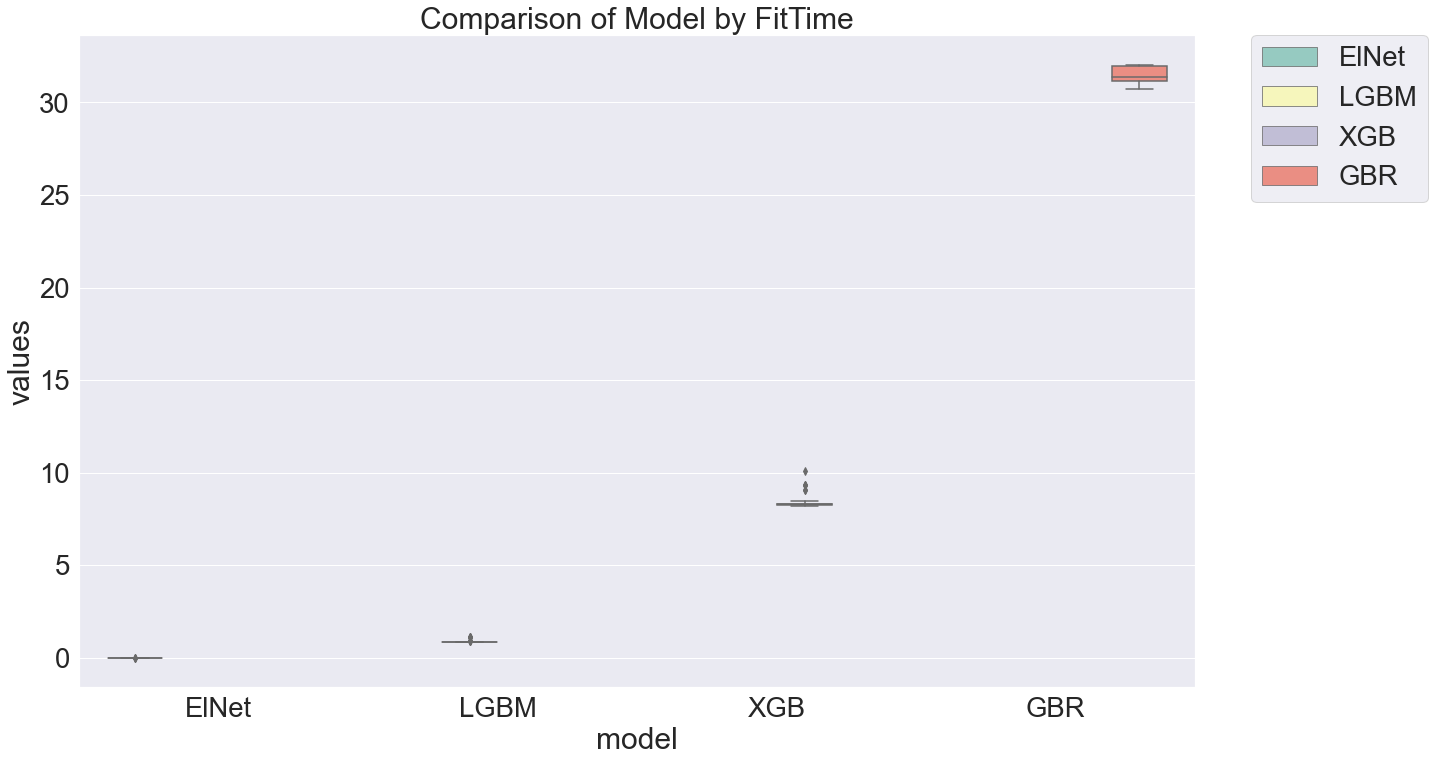

In [30]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="model", data=results_long_fit[(results_long_fit.metrics =='fit_time') & 
                                                                            (results_long_fit.model != 'Stack') &
                                                                           (results_long_fit.model != 'SVR')], palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by FitTime')

In [31]:
metric_df['values'] = (metric_df['values']*(-1))**(1/2)
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

test_neg_mean_squared_error               test_r2            \
                              std        mean       std      mean   
model                                                               
ElNet                    7.198178 -692.111068  0.003716  0.315987   
GBR                      8.718909 -575.017558  0.005280  0.431063   
LGBM                     8.718324 -575.427610  0.004863  0.430169   
SVR                      8.993714 -578.385550  0.005756  0.427543   
Stack                    7.991598 -565.796736  0.004971  0.439657   
XGB                      7.673746 -568.105725  0.005346  0.437257   

      test_neg_mean_absolute_error            Unnamed: 0         
                               std       mean        std   mean  
model                                                            
ElNet                     0.085801 -19.743615   4.469443  81.94  
GBR                       0.094312 -17.315451   4.329538  51.30  
LGBM                      0.122784 -17.104273   4.514150  36.70  
SVR                       0.114504 -16.944943   4.190173  66.44  
Stack                     0.096275 -17.109121   4.317076   7.66  
XGB                       0.098913 -17.061463   3.830916  23.24

In [32]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.std, np.mean])

score_time              fit_time            
             std      mean         std        mean
model                                             
ElNet   0.000496  0.002874    0.001046    0.007962
GBR     0.001604  0.043653    0.387586   31.475849
LGBM    0.003247  0.069895    0.081258    0.881670
SVR     1.112672  9.002675   22.523213  175.461544
Stack   1.262490  8.717453  107.462771  878.731737
XGB     0.001961  0.019837    0.380306    8.407435

In [33]:
GBR = pickle.load(open('models/GBR.sav', 'rb'))
LGBM = pickle.load(open('models/LGBM.sav', 'rb'))
Stack = pickle.load(open('models/Stack.sav', 'rb'))
SVR = pickle.load(open('models/SVR.sav', 'rb'))
XGB = pickle.load(open('models/XGB.sav', 'rb'))
ElNet = pickle.load(open('models/ElNet.sav', 'rb'))

In [34]:
train_percentage = 0.8
cal_percentage = 0.2
n_total = X_train.shape[0]
n_train = int(train_percentage*n_total)
n_cal = int(cal_percentage*n_total) + n_train
train_data = X_train.iloc[:n_train, :]
train_target = y_train.iloc[:n_train]
cal_data = X_train.iloc[n_train:n_cal, :]
cal_target = y_train.iloc[n_train:n_cal]
test_data = X_test
test_target = y_test

In [35]:
def PI(model, level1, level2):
    
    # Default nonconformity measure
    nc = NcFactory.create_nc(model)
    # Inductive conformal regressor
    icp = IcpRegressor(nc)
    # Fit the ICP using the proper training set
    icp.fit(train_data.values, train_target.values)
    # Calibrate the ICP using the calibration set
    icp.calibrate(cal_data.values, cal_target.values)

    # Produce predictions for the test set
    prediction1 = icp.predict(test_data.values, significance=(1-level1))
    lower_1 = prediction1[:, 0]
    upper_1 = prediction1[:, 1]

    prediction2 = icp.predict(test_data.values, significance=(1-level2))
    lower_2 = prediction2[:, 0]
    upper_2 = prediction2[:, 1]

    df_50 = pd.DataFrame()
    df_80 = pd.DataFrame()
    df_50 = df_50.append(pd.DataFrame({'pred': model.predict(test_data.values),
                      'LB': lower_1,
                      'UB': upper_1}
                     ))
    
    df_80 = df_80.append(pd.DataFrame({'pred': model.predict(test_data.values),
                      'LB': lower_2,
                      'UB': upper_2}
                     ))
        
    return df_50, df_80

In [36]:
%%time
PI_LGBM = PI(LGBM,0.5,0.8)

[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
CPU times: user 18 s, sys: 908 ms, total: 18.9 s
Wall time: 7.29 s


In [37]:
%%time
PI_SVR = PI(SVR,0.5,0.8)

CPU times: user 4min 17s, sys: 2.32 s, total: 4min 20s
Wall time: 4min 33s


In [38]:
%%time
PI_ElNet = PI(ElNet,0.5,0.8)

CPU times: user 671 ms, sys: 45.5 ms, total: 717 ms
Wall time: 426 ms


In [39]:
%%time
PI_GBR = PI(GBR,0.5,0.8)

CPU times: user 43 s, sys: 328 ms, total: 43.4 s
Wall time: 45.3 s


In [40]:
%%time
PI_XGB = PI(XGB,0.5,0.8)

CPU times: user 28.6 s, sys: 499 ms, total: 29.1 s
Wall time: 10 s


In [41]:
%%time
PI_Stack = PI(Stack, 0.5,0.8)

CPU times: user 18min 48s, sys: 8.67 s, total: 18min 57s
Wall time: 16min 55s


In [42]:
def intervalScore(predObj,actual,level):
    n = len(predObj)
    alpha = 1 - level
    upper = predObj.loc[:,'UB']
    lower = predObj.loc[:,'LB']
    ilow = (actual.values<lower)
    ihigh = (actual.values>upper)
    sumlength = sum(upper-lower)
    sumlow = sum(predObj.loc[ilow,'LB']-actual.values[ilow])*2/alpha
    sumhigh = sum(actual.values[ihigh]-predObj.loc[ihigh,'UB'])*2/alpha
    avglength = sumlength/n
    IS = (sumlength+sumlow+sumhigh)/n # average length + average under/over penalties
    cover = ((actual.values>= lower) & (actual.values<=upper)).mean()
    summ = pd.DataFrame(np.array([[level,avglength,IS,cover]]), columns = ['level','avglength', 'IS', 'cover'])
    return summ

In [43]:
intervalScore(PI_LGBM[0], test_target, 0.5)

,level,avglength,IS,cover
0,0.5,23.675021,58.053079,0.493913


In [44]:
intervalScore(PI_LGBM[1], test_target, 0.8)

,level,avglength,IS,cover
0,0.8,54.604375,89.739934,0.79847


In [45]:
intervalScore(PI_GBR[0], test_target, 0.5)

,level,avglength,IS,cover
0,0.5,24.705315,58.111231,0.506226


In [46]:
intervalScore(PI_GBR[1], test_target, 0.8)

,level,avglength,IS,cover
0,0.8,54.745685,89.172403,0.794574


In [47]:
intervalScore(PI_XGB[0], test_target, 0.5)

,level,avglength,IS,cover
0,0.5,23.855599,57.693341,0.504765


In [48]:
intervalScore(PI_XGB[1], test_target, 0.8)

,level,avglength,IS,cover
0,0.8,54.164624,89.305558,0.799235


In [49]:
intervalScore(PI_ElNet[0], test_target, 0.5)

,level,avglength,IS,cover
0,0.5,29.155639,65.155167,0.50087


In [50]:
intervalScore(PI_ElNet[1], test_target, 0.8)

,level,avglength,IS,cover
0,0.8,64.46488,96.675231,0.798817


In [51]:
intervalScore(PI_SVR[0], test_target, 0.5)

,level,avglength,IS,cover
0,0.5,23.265512,57.622164,0.502122


In [52]:
intervalScore(PI_SVR[1], test_target, 0.8)

,level,avglength,IS,cover
0,0.8,53.119752,89.999795,0.792765


In [53]:
intervalScore(PI_Stack[0], test_target, 0.5)

,level,avglength,IS,cover
0,0.5,24.332938,57.656394,0.505113


In [54]:
intervalScore(PI_Stack[1], test_target, 0.8)

,level,avglength,IS,cover
0,0.8,54.434832,88.648574,0.797217


| **Model** | **Level** | **Avg Length** | **IS** | **Coverage** | |
|---|---|---|---|---|---|
| LGBM | 0.5|23.675021|58.053079|0.493913 | |
| SVR | 0.5  | 23.266499  | 57.622133 | 0.502122 | |
| GBR | 0.5|24.705315|58.114026|0.506226 | |
|Elnet| 0.5|29.155639|65.155167|0.50087| |
| XGB | 0.5|23.855599|57.693341|0.504765 | |
| Stack | 0.5 | 24.337802 | 57.656382 |0.505113 | * |

| **Model** | **Level** | **Avg Length** | **IS** | **Coverage** | |
|---|---|---|---|---|---|
| LGBM | 0.8|54.604375|89.739934|0.79847 | |
| SVR | 0.8 | 53.119757 | 89.999751 | 0.792765 | |
| GBR | 0.8|54.755009|89.174804|0.794643 | |
|ElNet| 0.8|64.46488|96.675231|0.798817 | |
| XGB | 0.8|54.164624|89.305558|0.7992355 | |
| Stack | 0.8 | 54.447974 | 88.648392 |0.797287|* |

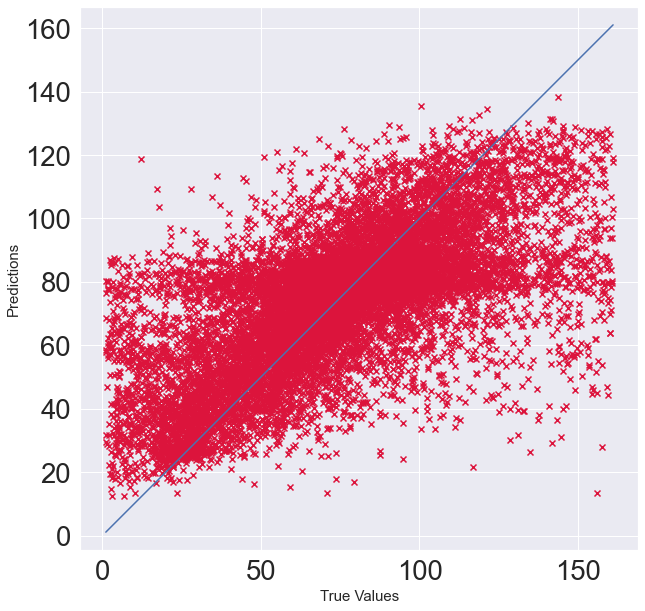

In [56]:
plt.figure(figsize=(10,10))
plt.scatter(test_target, PI_Stack[0].iloc[:,0], c='crimson',marker = 'x')

p1 = max(max(PI_Stack[0].iloc[:,0]), max(test_target))
p2 = min(min(PI_Stack[0].iloc[:,0]), min(test_target))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

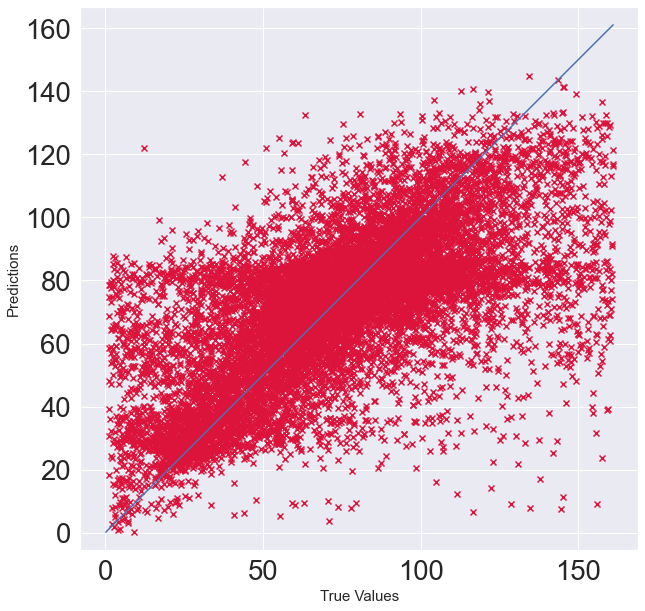

In [62]:
plt.figure(figsize=(10,10))
plt.scatter(test_target, PI_SVR[0].iloc[:,0], c='crimson',marker = 'x')

p1 = max(max(PI_SVR[0].iloc[:,0]), max(test_target))
p2 = min(min(PI_SVR[0].iloc[:,0]), min(test_target))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()